
# Isoform Peptide multi-mapping 
file in order to look thru the AllPeptides file 
- find the genes and isoforms and the peptided
- find if the gene is multi-mapping or not 

In [1]:
import os
from huvec_analysis import huvec_config
# from huvec_analysis.data_loader import genes_in_hiconf_space, accs_in_hiconf_space
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from Bio import SeqIO
import os 
import matplotlib

matplotlib.rc('font', **huvec_config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')


In [2]:

#read in the file paths 
#toy_fasta_file = f'{huvec_config.REFERENCE_DIRECTORY}/huvec_toy.fasta'
fasta_file = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/hybrid_protein_database/huvec_hybrid.fasta'
pacbio_protein_grps_path = '../00_pre_analysis/metamorpheus_table/AllProteinGroups.PacBioHybrid.tsv'
pacbio_peps_path = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/metamorpheus/pacbio/hybrid/search_results/Task1SearchTask/AllPeptides.huvec.hybrid.psmtsv'
pacbio_peps_filtered_path = '../00_pre_analysis/metamorpheus_table/AllPeptides.PacBioHybrid.tsv'
sqanti_info_path = '../00_pre_analysis/sqanti_info/sqanti_info.tsv'
# make a toy file of the peps file 
# read in the peps file 
pacbio_peps_filtered = pd.read_table(pacbio_peps_filtered_path)

#read in the sqanti table for com information 
sqanti_info = pd.read_table(sqanti_info_path)
#%%
# Gene|isoform|has_unique_peptide (yes.no)|listing of the unique peptides 
# read in the fasta file with the biopython module 
##test whih part of the sequence we are extracting 

fasta_sequences_pb = SeqIO.parse(fasta_file, 'fasta')

def find_trans_matches(peptide_seq, fasta_seq):
    '''
    Reading through the fasta sequence find if there is a matching 
    peptide within the fasta sequence
    if so then the transcript id of the match will be returned'''
    transcript_ids = []
    for trans_id, sequence in fasta_seq.items(): 
       # print (trans_id, sequence)
        
        if peptide_seq in sequence:
            transcript_ids.append(trans_id)
        #break
    return transcript_ids
    #return seq.description

#create dict
#create dictionary for the pacbio sequences
def process_fasta_file_pb(fasta_file_pb):
    """
    For configuration, to convert the global fasta sequence file into a 
    sequence dictionary that can be used in mapping
    Parameters
    ---------
    fasta_file : str
        file location of fasta file
    Returns
    ---------
    sequences : dict
        {acc : sequence} dictionary generated from fasta file
    """
    seqs = SeqIO.parse(open(fasta_file_pb), 'fasta')
    sequences = {}
    for entry in seqs:
        seq = str(entry.seq)
        #acc = entry.description.split('|')[1].strip()
        acc = entry.description
        sequences[acc] = seq
    return sequences

#apply the function to the pb fata file 
fasta_sequences_pb = process_fasta_file_pb(fasta_file)


In [5]:

#apply the functions and add to the peps table to find what transcripts we have from pacbio present within gencode
# Perform for the entire length of the rows for AllPeptides file
pacbio_peps_filtered['transcripts_pb']=pacbio_peps_filtered.apply(lambda row:find_trans_matches(row['Base Sequence'],fasta_sequences_pb),axis=1)

# convert the list to a string for searching downstream
pacbio_peps_filtered['transcripts_pb_str'] = pacbio_peps_filtered['transcripts_pb'].astype(str)
#find the rows that have more than 1 accession listed (based on the comma)

# find where the length of the list is greater than 1 (meaning there is is not unique)
def has_multiple(group):
    return len(group) <=1
pacbio_peps_filtered['has_one_iso'] = pacbio_peps_filtered['transcripts_pb'].apply(has_multiple)

# converts the True false to 1 for yes 0 for no
pacbio_peps_filtered['peptide_is_unique'] = pacbio_peps_filtered['has_one_iso'].astype(int)
pacbio_peps_filtered.to_csv('stats/peptide_isoform_coverage.tsv', sep='\t')


In [ ]:

unique_isos = pacbio_peps_filtered[pacbio_peps_filtered['peptide_is_unique']==1]
unique_isos = unique_isos[['gene_name', 'Protein Accession', 'peptide_is_unique',  'ec_priority', 'Base Sequence']]

# find the unique EC peptides
ec_unique_isos = unique_isos[unique_isos['ec_priority']==1]
ec_unique_isos.to_csv('stats/ec_genes_unique_isos.tsv', sep = '\t')

# find the number of multi-mapping isoforms
not_unique_isos = pacbio_peps_filtered[pacbio_peps_filtered['peptide_is_unique']==0]



In [23]:
unique_isos

,gene_name,Protein Accession,peptide_is_unique,ec_priority,Base Sequence
4,FASN,PB.11465.3,1,0,GTHTGVWVGVSGSETSEALSRDPETLVGYSMVGCQR
12,KIF5B,KIF5B-201,1,0,ANLEAFTVDKDITLTNDKPATAIGVIGNFTDAER
13,DNAJB4,PB.601.8,1,0,EIYDQFGEEGLKGGAGGTDGQGGTFR
14,PGRMC2,PB.3557.2,1,0,GLATFCLDKDALRDEYDDLSDLNAVQMESVR
26,YBX1,PB.423.4,1,0,SVGDGETVEFDVVEGEKGAEAANVTGPGGVPVQGSK
...,...,...,...,...,...
99914,RAB23,PB.4710.1,1,0,MVVVGNGAVGK
99918,RBM10,PB.13615.5,1,0,MLPQAATEDDIRGQLQSHGVQAR
99919,ISG15,ISG15-203,1,0,GWDLTVK
99920,LPCAT1,LPCAT1-201,1,0,ITFADFHR


In [34]:
 # find for how many isoforms we have exactly 2 unique accessions (w/ ec gene column)
gene_multiple_w_ec_genes = unique_isos[['gene_name', 'Protein Accession', 'ec_priority']].drop_duplicates()
gene_multiple_w_ec_genes = gene_multiple_w_ec_genes.groupby(['gene_name', 'ec_priority']).size().reset_index(name='size')
one_uniq_iso = gene_multiple_w_ec_genes[gene_multiple_w_ec_genes['size'] == 1]
gene_multiple_w_ec_genes = gene_multiple_w_ec_genes[gene_multiple_w_ec_genes['size'] > 1]
gene_multiple_w_ec_genes.to_csv('stats/genes_w_multiple_w_ec_genes.tsv', sep = '\t', index = None)

# find for how many genes there are exactly 2 isoforms for a gene with unique peptide evidence 
two_uniq_isos = gene_multiple_w_ec_genes[gene_multiple_w_ec_genes['size']==2]

ec_genes_two_uniq_isos = gene_multiple_w_ec_genes[(gene_multiple_w_ec_genes['size']==2) & (gene_multiple_w_ec_genes['ec_priority']==1)]

three_uniq_isos = gene_multiple_w_ec_genes[gene_multiple_w_ec_genes['size']==3]

four_uniq_isos = gene_multiple_w_ec_genes[gene_multiple_w_ec_genes['size']==4]

# merge the sqanti info with the peptides table for cpm information 
pacbio_peps_filtered['pr_acc'] = pacbio_peps_filtered['Protein Accession'].str.split('|')

# supplementary table outp
#TODO needs cpm merged in 
supp_table_isoform_informative = pacbio_peps_filtered[['gene_name', 'Protein Accession', 'peptide_is_unique']]
supp_table_isoform_informative.to_csv('stats/supp_table_isoform_informative_table.tsv', sep = '\t')



In [28]:
unique_isos[['gene_name', 'Protein Accession']].drop_duplicates()

,gene_name,Protein Accession
4,FASN,PB.11465.3
12,KIF5B,KIF5B-201
13,DNAJB4,PB.601.8
14,PGRMC2,PB.3557.2
26,YBX1,PB.423.4
...,...,...
99881,PAPPA,PAPPA-201
99899,WDR76,PB.9711.3
99903,RHEB,PB.5722.5
99919,ISG15,ISG15-203


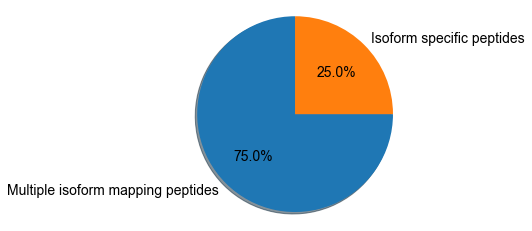

In [29]:
peptide_map_sizes = supp_table_isoform_informative.groupby('peptide_is_unique').size()

# Genreration of the pie charts to find the percentage of the multi-mapping vs the unique 
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Multiple isoform mapping peptides', 'Isoform specific peptides']
sizes = [
        round(peptide_map_sizes.loc[0] / peptide_map_sizes.sum() * 100), 
        round(peptide_map_sizes.loc[1] / peptide_map_sizes.sum() * 100)]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('plot/isoform_informative_percents.pdf',bbox_inches='tight')


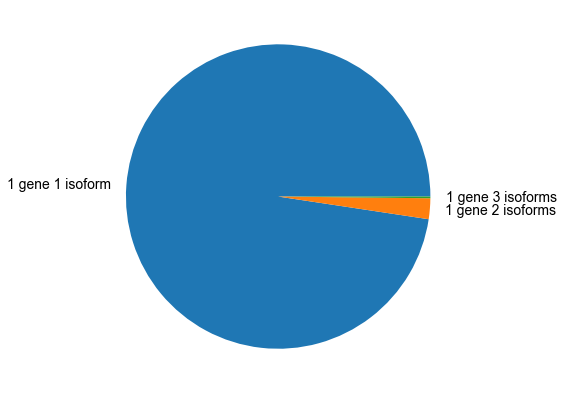

In [33]:


# gene level analysis of isoform informative analysis 
# of the unique isoforms detected where were there genes where multiple unique isoforms for that gene were defined with peptide evicence 
#%%
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [
    '1 gene 1 isoform', 
    '1 gene 2 isoforms', 
    '1 gene 3 isoforms', 
    # '1 gene 4 isoforms'
    ] 
 
 
data = [
    len(one_uniq_iso), 
    len(two_uniq_isos), 
    len(three_uniq_isos), 
    # len(four_uniq_isos)
    ]
 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels)
 
# show plot
plt.show()
